### Solving an eigenvalue problem using a neural network

In this notebook, we set a random initial condition and let our network find the solution to the ODE:
$$     \frac{dx}{dt} = -x(t) + f( x (t))  ,$$
This should reproduce what we found by solving this with forward Euler, and the same initial condition, but that does not happen. Throughout the notebook we investigate why.
**Note: Tensorflow is needed to run the notebook**

In [1]:
import os, sys
sys.path.append(os.path.join(os.getcwd(), "../"))
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import eigenSolverNN as esnn
import importlib
import plotter
import eigenSolverFE as esfe
import Eigenvects
import time

2022-12-16 21:06:09.116372: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [94]:
# the matrix to diagonalize
A = tf.convert_to_tensor(np.load("A.npy"))
# random initial condition for our system
x0 = np.array([-0.99581536, -0.44185623 , -0.72648535,  0.42184483, -0.4879591 , 0.32223256])
x0 = tf.convert_to_tensor(x0)

In [56]:
#initialize solver
optim = tf.keras.optimizers.Adam()
tmax=2
npts=100
solver = esnn.eigSolverNN(A, x0, optimizer=optim, Tmax=tmax, N_tpoints=npts)

In [57]:
#train model
Nepochs = 100000
#can optionally turn on stochastic gradient descent by using more than one batch
Nbatches = 1
solver.train_model(Nepochs, Nbatches)

------ Current settings of model: ------

Model:
Layers:
[<keras.layers.core.dense.Dense object at 0x7f5cb0592860>, <keras.layers.core.dense.Dense object at 0x7f5cb0591870>]
Number of neurons in hidden layer: 100
Optimizer: Adam
Learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.001>
Time grid has shape (100, 1) and goes from [0.] to [2.]
Starting from initial condition: [-0.99581536 -0.44185623 -0.72648535  0.42184483 -0.4879591   0.32223256]


 Training model with SGD using 1 batches and 100000 epochs.


100%|██████████████████████████████████| 100000/100000 [03:19<00:00, 502.10it/s]


losses were: initial 39.22411421494044, last: 0.015033334883163073


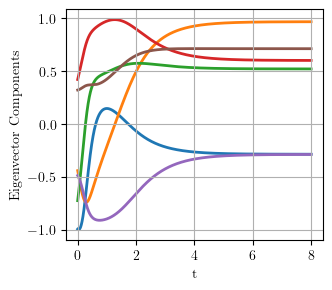

In [103]:
#compute fwd euler solution for comparison
importlib.reload(esfe)
Anp = solver.A.numpy()
Tmax = 8
Nsteps = 4000
tFE, xFE = esfe.forward_euler_sol(Anp, x0.numpy(), Tmax, Nsteps)
_ = plotter.plot_eigenvector_components_convergence(tFE, xFE)

eigFE = xFE[:,-1]

In [65]:
#check that we found an eigvec using the neural net
eigval, eigvec = solver.compute_eig()
true_eigvals, true_eigvecs = tf.linalg.eigh(A)
print(f"eigenvalue found with nn: {(eigvec @ A @ tf.transpose(eigvec))/tf.norm(eigvec)**2}")
print(f"eigenvalues computed with library function: {true_eigvals}" )
print(f"relative error:{np.abs( (true_eigvals[0]-eigval)/true_eigvals[0]) }")

eigenvalue found with nn: [[-2.30655464]]
eigenvalues computed with library function: [-2.30656508 -1.54248674 -0.53955334  0.19045441  1.68567193  2.20200564]
relative error:[[4.52764893e-06]]


In [64]:
#check that the nn eigenvector is parallel to the library one:
def parallel_check(v,w):
    '''should return 1 if v and w are parallel'''
    num = np.dot(v,w)**2
    den = np.dot(v,v)*np.dot(w,w)
    
    return num/den

#if eigvec is parallel to true_eigvecs[:,0] we should find zero here
print(f"{1-parallel_check(eigvec.numpy().reshape(-1), true_eigvecs[:,0])}")

6.4196989710829655e-06


()


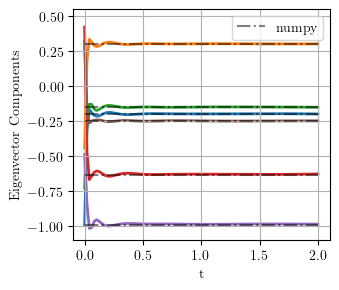

In [108]:
#plot trained x_tilde
t= solver.t_grid
time_evo = tf.transpose(solver.x_tilde(t))
fig1 = plotter.plot_eigenvector_components_convergence(t,time_evo)
#plot also the corresponding eigenvector components
ax = fig1.axes[0]
#to renomalize it compute ratio between first components 
ratio= eigvec[:,0]/true_eigvecs[0,0]
print(true_eigvecs[jj,0].shape)
for jj in range(6):
    ax.plot([0,2], ratio*true_eigvecs[jj,0]*np.ones(2), color='black', linestyle='-.', alpha=0.5)
ax.lines[6]._label = "numpy"
ax.legend()
ax.set_ylim([-1.1, 0.55])
fig1.savefig("NN_solution.pdf", bbox_inches='tight')

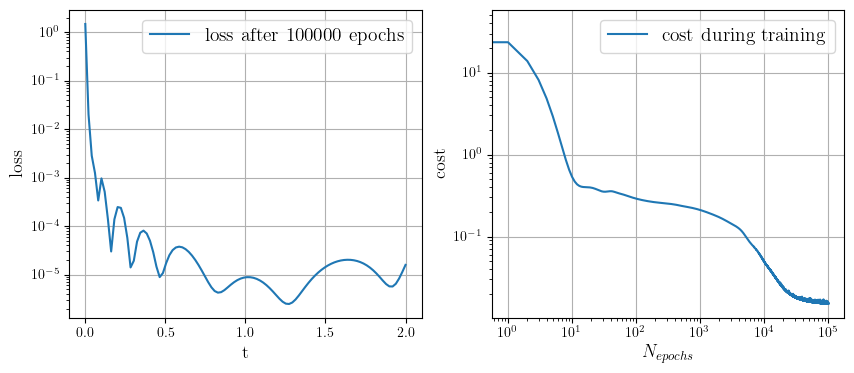

In [117]:
#plot loss at every timestep
Nepochs = 100000
individual_losses = [solver.loss(t) for t in solver.t_grid ]
fig2, ax2 = plt.subplots(1,2, figsize=(10,4))

ax2[0].plot(solver.t_grid, individual_losses, label=f"loss after {Nepochs} epochs") 
ax2[0].set_ylabel('loss', fontsize=13)
ax2[0].set_xlabel('t', fontsize=13)
ax2[0].set_yscale('log')
ax2[0].legend(fontsize=14)
ax2[0].grid()

ax2[1].plot(np.arange(Nepochs), solver.losses, label=f"cost during training")
ax2[1].grid()
ax2[1].set(xscale="log", yscale="log")
ax2[1].set_ylabel("cost", fontsize=13)
ax2[1].set_xlabel("$N_{epochs}$", fontsize=13)
ax2[1].legend(fontsize=14)
fig2.savefig("ODE_NN_loss.pdf", bbox_inches='tight')

### Second loop (not relevant and not included in report)
We just experimented the effect of setting a new initial condition orthogonal to the eigenvector previously found. This has poor results.

In [227]:
#CHECK ORTHOGONALITY
eigvec_np = eigvec.numpy().reshape(-1)
x0new = Eigenvects.create_orthogonal([eigvec_np])
print(np.dot(x0new, eigvec_np))

-2.220446049250313e-16


In [228]:
timegrid =  tf.linspace(0,1, 100)[:,tf.newaxis]
solver_2 = esnn.eigSolverNN(A, x0new, t_grid=timegrid )

In [229]:
Nepochs=50000
Nbatches = 4
solver_2.train_model(Nepochs, Nbatches)

------ Current settings of model: ------

Model:
Layers:
[<keras.layers.core.dense.Dense object at 0x7f0eea861a50>, <keras.layers.core.dense.Dense object at 0x7f0eea860c10>]
Number of neurons in hidden layer 100
Optimizer: Adam
Learning rate: <tf.Variable 'learning_rate:0' shape=() dtype=float32, numpy=0.001>
Time grid has shape (100, 1) and goes from [0.] to [1.]
Starting from initial condition [-0.56617808 -1.85977716 -0.10646654  1.15221388  0.41675127 -0.3148309 ]


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [08:38<00:00, 96.42it/s]


losses were: initial 35317.83524713627, last: 0.006123768700905234


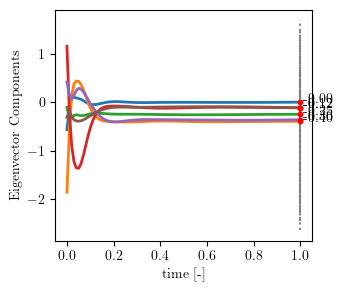

In [230]:
t = solver_2.t_grid
time_evo = tf.transpose(solver_2.x_tilde(t))
_ = plotter.plot_eigenvector_components_convergence(t,time_evo)

In [258]:
eigval, eigvec = solver_2.compute_eig()
eigvec = tf.transpose(eigvec)
v_i = A @ eigvec
supposed_eigval = (v_i/eigvec)
print(supposed_eigval)
print(np.mean(supposed_eigval))

tf.Tensor(
[[-27.61075084]
 [ -2.72994974]
 [ -2.7136497 ]
 [ -2.50821541]
 [ -2.80659709]
 [ -2.53297297]], shape=(6, 1), dtype=float64)
-6.817022625190155


array([-0.56617808, -1.85977716, -0.10646654,  1.15221388,  0.41675127,
       -0.3148309 ])

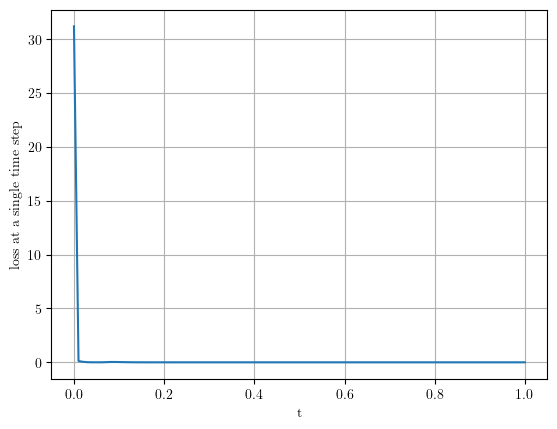

In [234]:
#plot loss at every timestep
a = [solver_2.loss(t) for t in solver_2.t_grid ]
plt.plot(solver_2.t_grid, a) 
plt.ylabel('loss at a single time step')
plt.xlabel('t')
plt.grid()
x0new